# Estimating the real mortality rate for COVID-19

In this project, we attempt to estimate the mortality rate for COVID-19 (the "new coronavirus") while controlling for country-level covariates such as access to healthcare and age of population.

The observed mortality of COVID-19 has varied widely from country to country (as of early March 2020), which makes it difficult to get a handle on the actual mortality rate of the virus.  For instance, as of March 10, mortality rates have ranged from < 0.1% in places like Germany (1100+ cases) to upwards of 5% in Italy (9000+ cases) and 3.9% in China (80k+ cases).

As of March 10, the **overall reported mortality rate is 3.5%**.  However, this figure does not account for systematic biases in case reporting and testing in countries for which the outbreak is more mature.

The point of our modelling work here is to **try to understand and correct for the country-to-country differences that may cause the observed discrepancies in COVID-19 country-wide mortality rates**.  That way **we can "undo" those biases and try to pin down an overall *real* mortality rate**.

### Country-level covariates
We've listed out few of the factors that may account for observed differences in mortality rates:

1. **Time since first case.**  There is a delay between the time a victim contracts COVID-19 and eventually succumbs from it.  Since the outbreak is at different stages for each country, this should be accounted for.  We expect higher mortality rates in countries for which the outbreak is more mature.
2. **Government transparency.**  Data about cases and deaths are typically reported by government agencies.  In less transparent governements, those numbers may be suppressed.  I would *expect* that cases are more easy to be suppressed than deaths, so the hypothesis is that less transparent governments have higher observed mortality rates.
3. **Healthcare access.**  If COVID-19 tests are not easily available, the case count will be under-reported.  On the flip-side, survival may be more likely in countries with better healthcare access.
4. **Population age.**  It has been reported that COVID-19 is more lethal to older individuals.  Since I do not have the counts broken down by age demographics, I'd broadly expect countries with older populations to have higher mortality rates.

In [1]:
# Setup and imports
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import pymc3 as pm

from source import data, model

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [17]:
# Load the data (see source/data.py):
df = data.get_all_data()

# Impute NA's column-wise:
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)

Dropping 38/146 countries due to lack of data
Dropping 77/108 countries w/o test per capita data


#### First we do some exploratory data analysis, plotting the country-wise covariates against each other and the country-wise COVID-19 mortality rates.

In [18]:
print('Overall observed mortality rate: %.2f%%' % (100.0 * df['deaths'].sum() / df['cases'].sum()))

Overall observed mortality rate: 4.09%


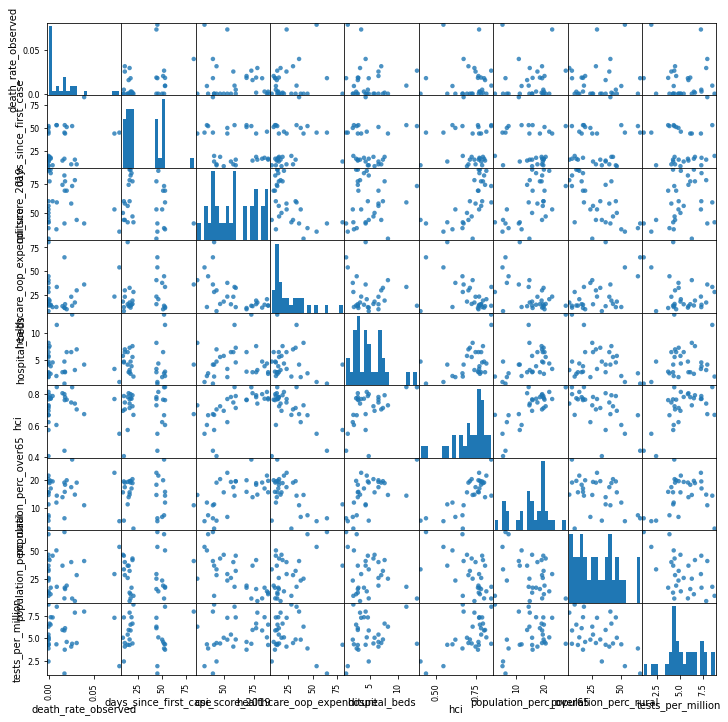

In [19]:
pairs = pd.plotting.scatter_matrix(df[df.columns[2::]], figsize=(12, 12),
                        hist_kwds={'bins': 20}, s=80, alpha=.8)

In [20]:
# Show the 15 countries with highest number of cases:
df.sort_values('cases', ascending=False).head(15)

,cases,deaths,death_rate_observed,days_since_first_case,cpi_score_2019,healthcare_oop_expenditure,hospital_beds,hci,population_perc_over65,population_perc_rural,tests_per_million
Country/Region,,,,,,,,,,,
Mainland China,81003,3203,0.039542,83.0,41.0,35.906185,4.200000,0.673,10.920884,40.848,7.944634
Italy,24747,1809,0.073100,44.0,53.0,23.105705,3.400000,0.769,22.751680,29.562,7.258764
"Korea, South",8162,75,0.009189,53.0,59.0,33.310328,11.500000,0.845,14.418556,18.541,8.482871
France,4513,91,0.020164,51.0,69.0,9.756244,6.500000,0.765,20.034625,19.556,4.593098
US,3499,63,0.018005,53.0,69.0,11.086677,2.900000,0.762,15.807654,17.744,3.732896
Norway,1221,3,0.002457,18.0,84.0,14.519657,3.900000,0.771,17.049222,17.752,7.322841
United Kingdom,1144,21,0.018357,44.0,77.0,15.117967,2.800000,0.781,18.395866,16.602,6.111024
Netherlands,1135,20,0.017621,17.0,82.0,11.451386,4.755172,0.800,19.196193,8.510,5.858504
Denmark,875,2,0.002286,17.0,87.0,13.712369,2.500000,0.774,19.812953,12.126,6.500388


# Model

The approach here is to fit a hierarchical Bayes Binomial model on the case & death counts, while also controlling for the country-level covariates using a GLM with logit link function for the country-level mortality rates.

All model code (using pymc3) can be found in source/model.py.

### Mathematical description of model
For those desiring more detailed information about the model, please refer to the text below:

![alt text](docs/model_description.png "Mathematical Details")

### A note about normalization
Critical to the interpretation of mu_0 as the "global, de-biased mortality rate" is that the individual covariates be normalized in a way that makes that interpretation valid.  What I mean by this is that the case where all country-level covariates are equal to 0 should reflect a country whose individual mortality rate is "as close to the true global rate as we can expect."

With respect to the covariates that we used in this analysis, this translates to:

+ "days since first case" - normalize so the **highest** value is zero.  We want to know what the rates look like when the outbreak is fully mature.
+ "cpi score" - normalize so the **highest** value is zero.  The most transparent goverments should have the least biased rates.
+ "healthcare oop expenditure" - normalize so the **mean** value is zero - to be agnostic to the affect of public vs. private healthcare systems. 
+ "hospital beds per capita" - normalize so the **highest** value is zero. More hospital beds likely means more access to care and testing. 
+ "HCI" - normalize so the **highest** value is zero.  HCI is a proxy for quality of healthcare and education.
+ "% population over 65" - normalize so **mean** value is zero, to reflect the world age demographic as closely as possible.
+ "% population rural" - normalize so **mean** value is zero, to reflect the world urban/rural demographic as closely as possible.

In [21]:
# Initialize the model:
# import importlib
# importlib.reload(model)
mod = model.initialize_model(df)

In [22]:
# Run MCMC sampler
with mod:
    trace = pm.sample(100, tune=200,
                      chains=3, cores=3)


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau, mu_model_logit, sigma, beta, sig_0, mu_0]
Sampling 3 chains, 174 divergences: 100%|██████████| 900/900 [00:36<00:00, 24.42draws/s]
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6896664739262534, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5181825372837007, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some param

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d5b2ac8>,
      dtype=object)

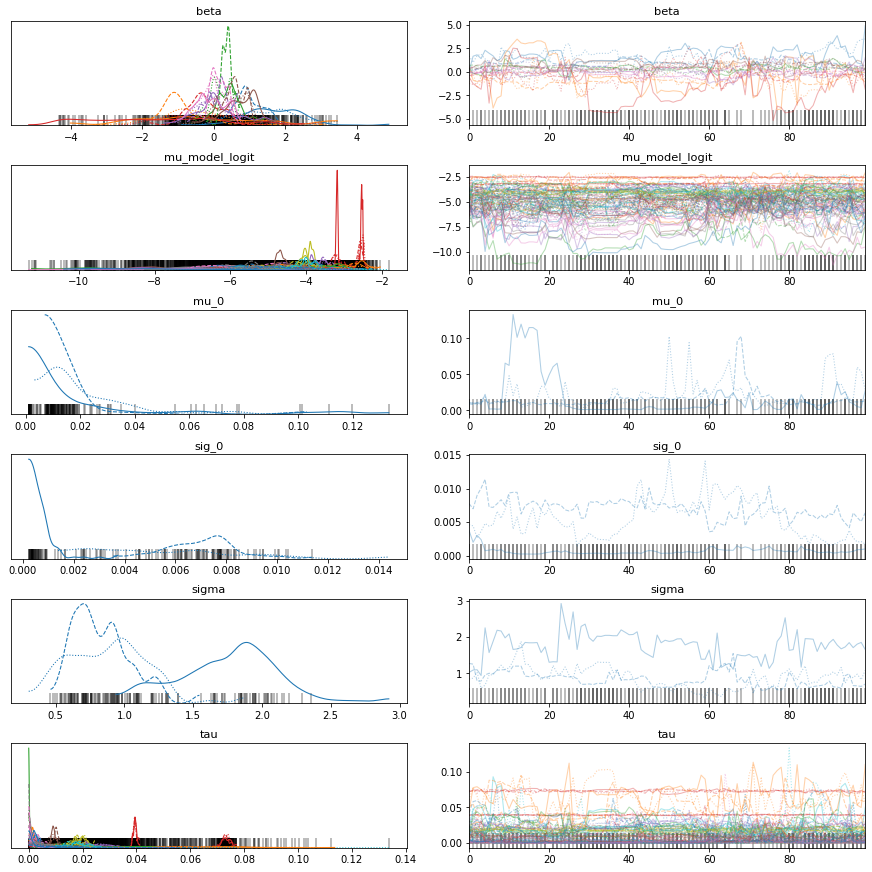

In [23]:
# Visualize the trace of the MCMC sampler to assess convergence
pm.traceplot(trace)

(0.0, 0.05)

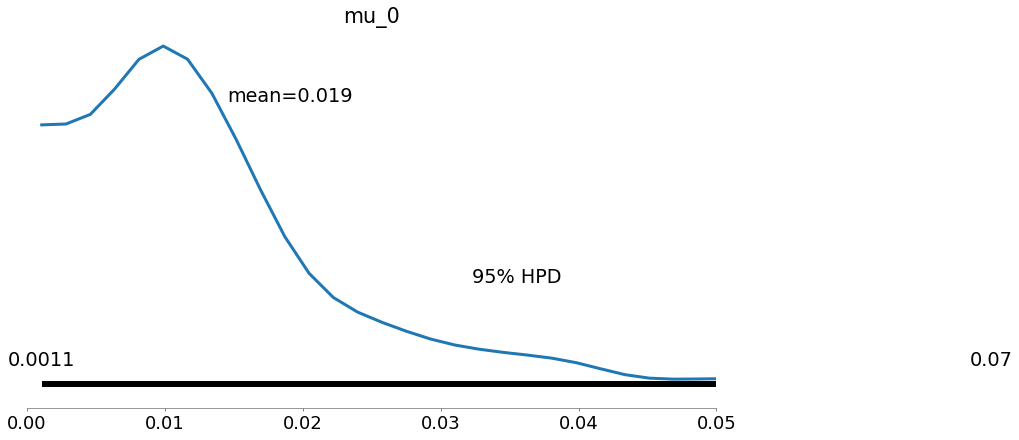

In [24]:
# Posterior plot for mu0
pm.plot_posterior(trace, var_names=['mu_0'], figsize=(14, 6), textsize=18,
                  credible_interval=0.95, bw=1.0, lw=3, kind='kde')
plt.xlim(0.0, 0.05)

In [11]:
n_samp = len(trace['mu_0'])
mu0_summary = pm.summary(trace).loc['mu_0']
print("COVID-19 Global Mortality Rate.")
print("Posterior mean: %0.3f" % trace['mu_0'].mean())
print("Posterior median: %0.3f" % np.median(trace['mu_0']))
lower = np.sort(trace['mu_0'])[int(n_samp*0.025)]
upper = np.sort(trace['mu_0'])[int(n_samp*0.975)]
print("95%% (2.5%% - 97.5%%) posterior interval: (%0.3f, %0.3f)" % (lower, upper))
print("95%% (HPD) posterior interval: (%0.3f, %0.3f)" % (mu0_summary['hpd_3%'], mu0_summary['hpd_97%']))

COVID-19 Global Mortality Rate.
Posterior mean: 0.006
Posterior median: 0.004
95% (2.5% - 97.5%) posterior interval: (0.001, 0.023)
95% (HPD) posterior interval: (0.001, 0.017)


In [25]:
# Posterior summary for the beta parameters:
beta_summary = pm.summary(trace).head(7)
beta_summary.index = ['days_since_first_case', 'cpi', 'healthcare_oop', 'tests_per_million', 'hci', 'percent_over65', 'percent_rural']
beta_summary.reset_index(drop=False, inplace=True)
beta_summary

,index,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,days_since_first_case,1.410,0.797,0.038,2.867,0.142,0.121,32.0,22.0,34.0,160.0,1.09
1,cpi,-0.592,1.267,-2.787,1.948,0.171,0.144,55.0,39.0,64.0,29.0,1.12
2,healthcare_oop,0.317,0.329,-0.433,0.779,0.044,0.031,57.0,57.0,51.0,45.0,1.11
3,tests_per_million,-0.611,1.480,-4.316,1.513,0.405,0.293,13.0,13.0,14.0,45.0,1.21
4,hci,0.082,0.538,-0.883,1.109,0.109,0.099,24.0,15.0,22.0,42.0,1.13
5,percent_over65,0.603,0.435,-0.149,1.411,0.100,0.071,19.0,19.0,19.0,76.0,1.15
6,percent_rural,0.016,0.347,-0.642,0.604,0.061,0.043,33.0,33.0,34.0,29.0,1.06


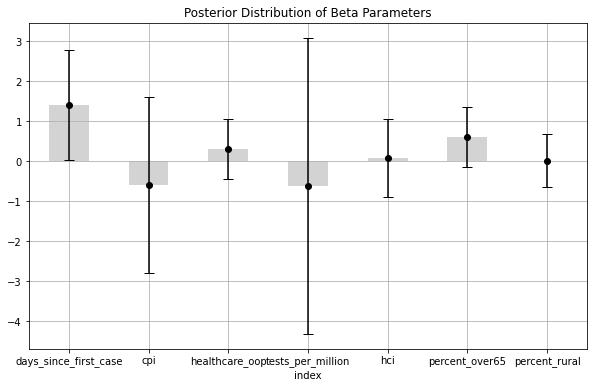

In [26]:
import matplotlib.pyplot as plt

err_vals = ((beta_summary['hpd_3%'] - beta_summary['mean']).values,
            (beta_summary['hpd_97%'] - beta_summary['mean']).values)
ax = beta_summary.plot(x='index', y='mean', kind='bar', figsize=(10, 6),
                 title='Posterior Distribution of Beta Parameters',
                 yerr=err_vals, color='lightgrey',
                 legend=False, grid=True,
                 capsize=5)
beta_summary.plot(x='index', y='mean', color='k', marker='o', linestyle='None',
                  ax=ax, grid=True, legend=False, xlim=plt.gca().get_xlim())

### Interpretation of beta parameters:

1. days_since_first_case - positive (very statistically significant).  As time since outbreak increases, expected mortality rate **increases**, as expected.
2. cpi - negative (statistically significant).  As government transparency increases, expected mortality rate **decreases**.  This is also as expected by our original hypothesis -- corrupt governments will under-report cases (but have a harder time under-reporting deaths), hence inflating the mortality rate.
3. healthcare OOP spending - no significant trend.
4. HCI - no significant trend.
5. percent over 65 - positive (statistically significant).  As population age increases, the mortality rate also **increases**, as expected.
6. percent rural - slightly negative (barely significant).  The more people that live in rural areas, the reported mortality rate **decreases**.  Sensible, given the reporting difficulties for rural populations.

These all seem very sensible, and help validate our numerical results.

## Conclusion

A couple of take-home points from the analysis.

1. The "best guess" estimate of mortality rate, once correcting for country-level factors, is only 0.5% -- as opposed to a 3.5% global mortality rate observed in the data.  The take-home here is that this is **driven by suppression in the reporting of cases**.  That is, **there are a lot more COVID-19 cases right now than are being reported!**  Likely a factor of ~7 more.
2. Given the current data, our bounds on the true mortality rate are (0.1%, 2%), meaning that we can not yet rule out mortality rates of up to 2%.
3. The contry-level factors that most impact the reported mortality rate are:
    * days since outbreak (more mature outbreak --> higher mortality)
    * gov't transparency index (more transparent --> lower reported mortality)
    * % of population over 65 (higher aged population --> higher mortality)
    * % of population rural (more rural --> lower reported mortality)
    
We will continue to re-run the analysis periodically as more data come in, to continually improve the precsion of the estimated mortality rate.  Further, as case data that is broken down by age range is made available, we can perform a more detailed estimate of mortality by age range.